# Make a background model with Gammapy

## Introduction 
We will see how to build a background model from existing data.

We are working with only 4 runs here, just as an example. To build a coherent bkg model you normally have to use AGN runs.

It will use:
        
-[gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the runs to use to build the bkg model
    
-[gammapy.data.ObservationGroupAxis](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationGroupAxis.html) and [gammapy.data.ObservationGroups](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationGroupAxis.html) to group the data to build the bkg model

-[gammapy.background.OffDataBackgroundMaker](http://docs.gammapy.org/en/latest/api/gammapy.background.OffDataBackgroundMaker.html) to make the acceptance curves in the different groups



## Import

In [59]:
import numpy as np
import astropy.units as u
from astropy.table import Column
import os
import shutil
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore, ObservationGroupAxis, ObservationGroups
from gammapy.background import OffDataBackgroundMaker
from gammapy.extern.pathlib import Path
from gammapy.catalog import load_catalog_tevcat

## Build a background model from existing data

To compute the acceptance curve we only use 4 dummy Crab runs from gammapy_extra: 23523, 23526, 23559 and 23592

In [60]:
cwd=os.getcwd()
if os.path.isdir(cwd+"/background"):
    shutil.rmtree(cwd+"/background")
data_store = DataStore.from_dir("$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2")


Prepare a scheme to group observations with similar observing conditions and create a new ObservationTable with the grouping ID for each run

In [61]:
# Create a background model from the 4 Crab runs for the counts ouside the exclusion region so here outside the Crab
# Create the directory for background storage
background_model_directory = cwd+"/background"
Path(background_model_directory).mkdir()

#Define the grouping you want to use to group the obervations to make the acceptance curves
# Here we use 2 Zenith angle bins only, you can also add efficiency bins for example etc...
axes = [ObservationGroupAxis('ZEN_PNT', [0, 49, 90], fmt='edges')]

# Create the ObservationGroups object
obs_groups = ObservationGroups(axes)
# write it to file
obs_groups.obs_groups_table.write(background_model_directory + "/group-def.fits", overwrite=True)

# Create a new ObservationTable with the column group_id
#You give the runs list you want to use to produce the background model that are in your obs table. 
#Here very simple only the 4 Crab runs...
list_ids=[23523,23526,23559,23592]
obs_table_with_group_id = obs_groups.apply(data_store.obs_table.select_obs_id(list_ids))


We need a mask to remove known sources from the observation. We use TeVcat and exclude a circular region of at least 0.3° radius. Here since we use Crab runs, we will remothe the Crab events from the FOV to select only the OFF events to build the acceptance curve. Of cource normally you use thousand of AGN runs to build coherent acceptance curve.

In [62]:
#Create the table that contains all the sources to exlude from the FOV for the PAC Man method to construct the acceptance curve
Tevcatsources = load_catalog_tevcat()
Tevcatsources.rename_column('coord_dec', 'DEC')
Tevcatsources.rename_column('coord_ra', 'RA')
radius=Tevcatsources["size_x"]
radius[np.where(Tevcatsources["size_x"] < Tevcatsources["size_y"])] = Tevcatsources["size_y"]
radius[np.isnan(radius)]=0.3
c = Column(radius, name='Radius')
Tevcatsources.add_column(c)





/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


Make the acceptance curve in the different group of observation conditions you defined above and from the obs_table containaing the group id for each observation used to compute the bkg model

In [63]:
bgmaker = OffDataBackgroundMaker(data_store, background_model_directory, run_list=None,
                                 obs_table=obs_table_with_group_id
                                 , ntot_group=obs_groups.n_groups, excluded_sources=Tevcatsources)
bgmaker.make_model("2D")

#Smooth the model
bgmaker.smooth_models("2D")

#Write the model
bgmaker.save_models("2D")
bgmaker.save_models(modeltype="2D", smooth=True)

In [64]:
### Plot the acceptance curve

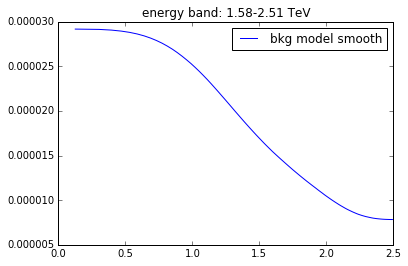

In [65]:
from gammapy.background import EnergyOffsetBackgroundModel
model=EnergyOffsetBackgroundModel.read(background_model_directory+"/smooth_background_2D_group_000_table.fits.gz")
offset=model.bg_rate.offset_bin_center
energies=model.bg_rate.energy  
iE=6
import pylab as plt
plt.ion()
plt.plot(offset, model.bg_rate.data[iE,:], label="bkg model smooth")
plt.title("energy band: "+str("%.2f"%energies[iE].value)+"-"+str("%.2f"%energies[iE+1].value)+" TeV")
plt.legend()


## New hdu table containing the background model

Here we first copy the dataset of the 4 crab runs from gammapy-extra to create the data you will use for the analysis. Here we use the same dataset to produce the bkg or for the analysis. Of course normally you produce the bkg model using thousands of AGN runs. 

Then we create a new hdu table containg for each observation a link to the bkg model to use depending of the observation conditions of the run

In [66]:

#Make a new hdu table in your dataset directory that contains the link to the acceptance curve to use to build the bkg model in your cube analysis
if os.path.isdir(cwd+"/data"):
    shutil.rmtree(cwd+"/data")
data_directory = cwd+"/data"
ds.copy_obs(ds.obs_table, data_directory)
data_store = DataStore.from_dir(data_directory)

#Create the new hdu table with a link to the background model
group_filename = background_model_directory + '/group-def.fits'
hdu_index_table = bgmaker.make_total_index_table(
    data_store=data_store,
    modeltype='2D',
    out_dir_background_model=cwd+"/background",
    filename_obs_group_table=group_filename, smooth=False
)

#Write the new hdu table
hdu_table_filename = data_directory  + '/hdu-index.fits.gz'
hdu_index_table.write(hdu_table_filename, overwrite=True)
